This requires the IEX_TOKEN environment variable to be set to the IEX API token.

In [1]:
from iexfinance.stocks import Stock, get_historical_data
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
df_spx = pd.read_csv('sp500_constituents.csv',encoding = "ISO-8859-1",quotechar='"')

In [3]:
df_pricechanges = pd.DataFrame(index=df_spx["Symbol"], 
                               columns=["Symbol", "Security", "GICS_Sector", "GICS_Sub_Industry", 
                                        "latestPrice", "lastweekPrice", "week52High", 
                                        "pct_change1D", "pct_change1W", "pct_changeFrom1YHigh"])


In [4]:
def retrieve_new_data():
    lastweek_date = datetime.today() - timedelta(days=7)
    print("Today:",datetime.today(),", Last week:",lastweek_date)

    for i in range(len(df_spx)):
        print("Retrieving " + df_spx["Symbol"][i] + "    ", end="\r", flush=True)
        df_pricechanges["Symbol"][i] = df_spx["Symbol"][i]
        df_pricechanges["Security"][i] = df_spx["Security"][i]
        df_pricechanges["GICS_Sector"][i] = df_spx["GICS_Sector"][i]
        df_pricechanges["GICS_Sub_Industry"][i] = df_spx["GICS_Sub_Industry"][i]

        quote = Stock(df_spx["Symbol"][i], output_format="json").get_quote()
        df_pricechanges["latestPrice"][i] = quote["latestPrice"]
        df_pricechanges["week52High"][i] = quote["week52High"]
        df_pricechanges["pct_change1D"][i] = quote["changePercent"]
        df_pricechanges["pct_changeFrom1YHigh"][i] = quote["latestPrice"] / quote["week52High"] - 1

        historical_data = get_historical_data(df_spx["Symbol"][i], start=lastweek_date.strftime("%Y%m%d"), close_only=True)
        df_pricechanges["lastweekPrice"][i] = historical_data[lastweek_date.strftime("%Y-%m-%d")]["close"]
        df_pricechanges["pct_change1W"][i] = quote["latestPrice"]/ df_pricechanges["lastweekPrice"][i]  - 1

In [5]:
def make_charts(data, value, title):
    data_subset = data[data.GICS_Sector.isin(["Communication Services", 
                                                               "Information Technology", 
                                                               "Consumer Staples", "Financials"])]
    if value == "pct_changeFrom1YHigh":
        hlines = [-0.25,-0.4, -0.5]
    else:
        hlines = [-0.05,-0.1]
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    plt.title(title + " drop")
    plt.scatter('Symbol', value, c=data.head(10).GICS_Sector.cat.codes, s=300, cmap='Set1', data=data.head(10))
    plt.hlines(hlines, xmin=-1, xmax=10, linestyles='dotted')
    plt.xlabel('Ticker')
    plt.ylabel('Change in price')

    plt.subplot(1,2,2)
    plt.title(title + " drop in tech, consumer staples, financials")
    plt.scatter('Symbol', value, c=data_subset.head(10).GICS_Sector.cat.codes, cmap='Set1', s=300, data=data_subset.head(10))
    plt.hlines(hlines, xmin=-1, xmax=10, linestyles='dotted')
    plt.xlabel('Ticker')
    plt.ylabel('Change in price')
    plt.show()

Choose whether to read an existing file or run the latest data from IEX

In [6]:
### Run latest data from IEX
retrieve_new_data()
df_pricechanges.head()
df_pricechanges.to_csv("results/pricechanges_" + datetime.today().strftime("%Y-%m-%d") + ".csv")
df_pricechanges.GICS_Sector = pd.Categorical(df_pricechanges.GICS_Sector)

In [7]:
### Read existing file
#df_pricechanges = pd.read_csv('results/pricechanges_2020-02-07.csv',encoding = "ISO-8859-1",quotechar='"')
#df_pricechanges.GICS_Sector = pd.Categorical(df_pricechanges.GICS_Sector)

Largest drops in the day

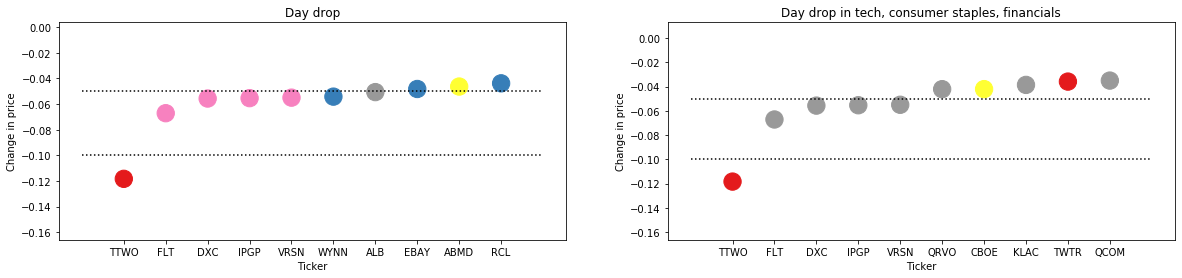

,Symbol,Security,GICS_Sector,GICS_Sub_Industry,latestPrice,pct_change1D
447,TTWO,Take-Two Interactive,Communication Services,Interactive Home Entertainment,112.625,-0.11833
188,FLT,FleetCor Technologies Inc,Information Technology,Data Processing & Outsourced Services,306.760,-0.06717
150,DXC,DXC Technology,Information Technology,IT Consulting & Other Services,32.700,-0.05573
247,IPGP,IPG Photonics Corp.,Information Technology,Electronic Manufacturing Services,133.610,-0.05543
472,VRSN,Verisign Inc.,Information Technology,Internet Services & Infrastructure,205.000,-0.05504
492,WYNN,Wynn Resorts Ltd,Consumer Discretionary,Casinos & Gaming,126.910,-0.05425
25,ALB,Albemarle Corp,Materials,Specialty Chemicals,82.540,-0.05072
152,EBAY,eBay Inc.,Consumer Discretionary,Internet & Direct Marketing Retail,36.165,-0.04829
6,ABMD,ABIOMED Inc,Health Care,Health Care Equipment,186.920,-0.04638
392,RCL,Royal Caribbean Cruises Ltd,Consumer Discretionary,"Hotels, Resorts & Cruise Lines",111.550,-0.04388


In [8]:
day_drop = df_pricechanges.sort_values(by=['pct_change1D'])[["Symbol", "Security", "GICS_Sector", 
                                                        "GICS_Sub_Industry", "latestPrice", "pct_change1D"]]
make_charts(day_drop, "pct_change1D", "Day")
day_drop.head(20)

Largest drops from 1 week

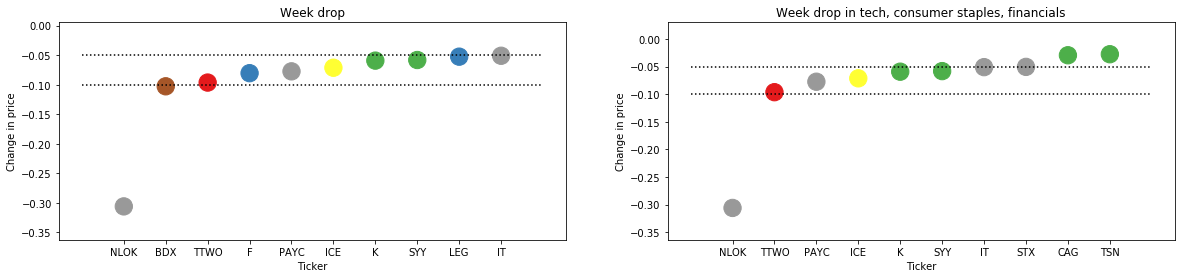

,Symbol,Security,GICS_Sector,GICS_Sub_Industry,latestPrice,lastweekPrice,pct_change1W
338,NLOK,NortonLifeLock,Information Technology,Application Software,19.720,28.42,-0.306122
62,BDX,Becton Dickinson,Health Care,Health Care Equipment,246.910,275.18,-0.102733
447,TTWO,Take-Two Interactive,Communication Services,Interactive Home Entertainment,112.625,124.64,-0.096398
174,F,Ford Motor,Consumer Discretionary,Automobile Manufacturers,8.110,8.82,-0.080499
360,PAYC,Paycom,Information Technology,Application Software,293.530,318.16,-0.077414
236,ICE,Intercontinental Exchange,Financials,Financial Exchanges & Data,92.630,99.74,-0.071285
263,K,Kellogg Co.,Consumer Staples,Packaged Foods & Meats,64.170,68.21,-0.059229
430,SYY,Sysco Corp.,Consumer Staples,Food Distributors,77.360,82.14,-0.058193
279,LEG,Leggett & Platt,Consumer Discretionary,Home Furnishings,45.090,47.59,-0.052532
252,IT,Gartner Inc,Information Technology,IT Consulting & Other Services,152.580,160.78,-0.051001


In [9]:
week_drop = df_pricechanges.sort_values(by=['pct_change1W'])[["Symbol", "Security", "GICS_Sector", 
                                                        "GICS_Sub_Industry", "latestPrice","lastweekPrice", "pct_change1W"]]
make_charts(week_drop, "pct_change1W", "Week")
week_drop.head(20)

Largest drops from 1 year high

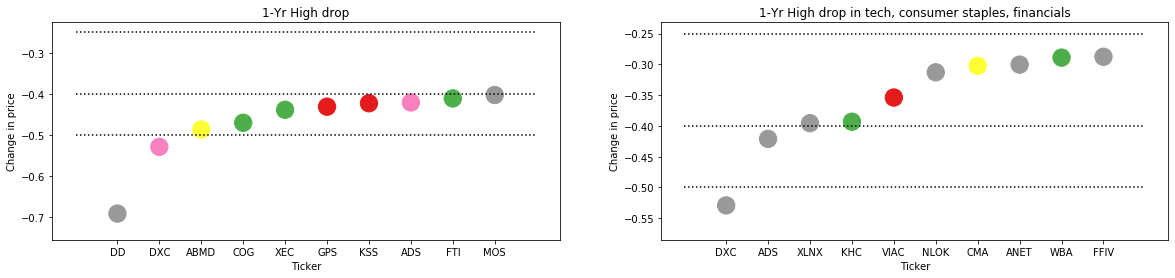

,Symbol,Security,GICS_Sector,GICS_Sub_Industry,latestPrice,week52High,pct_changeFrom1YHigh
129,DD,DuPont de Nemours Inc,Materials,Specialty Chemicals,52.550,170.46,-0.691717
150,DXC,DXC Technology,Information Technology,IT Consulting & Other Services,32.700,69.45,-0.529158
6,ABMD,ABIOMED Inc,Health Care,Health Care Equipment,186.920,364.31,-0.486920
108,COG,Cabot Oil & Gas,Energy,Oil & Gas Exploration & Production,14.640,27.65,-0.470524
493,XEC,Cimarex Energy,Energy,Oil & Gas Exploration & Production,43.060,76.74,-0.438885
208,GPS,Gap Inc.,Consumer Discretionary,Apparel Retail,17.850,31.39,-0.431348
274,KSS,Kohl's Corp.,Consumer Discretionary,General Merchandise Stores,43.800,75.91,-0.423001
13,ADS,Alliance Data Systems,Information Technology,Data Processing & Outsourced Services,105.920,182.95,-0.421044
194,FTI,TechnipFMC,Energy,Oil & Gas Equipment & Services,16.820,28.57,-0.411271
317,MOS,The Mosaic Company,Materials,Fertilizers & Agricultural Chemicals,20.250,33.91,-0.402831


In [10]:
yearhigh_drop = df_pricechanges.sort_values(by=['pct_changeFrom1YHigh'])[["Symbol", "Security", "GICS_Sector", 
                                            "GICS_Sub_Industry", "latestPrice", "week52High","pct_changeFrom1YHigh"]]
make_charts(yearhigh_drop, "pct_changeFrom1YHigh", "1-Yr High")
yearhigh_drop.head(40)